More work evaluating quality of topics.

In particular, identifying potential issues from words that appear too frequently across documents and show up in multiple topics as a result.

### Import packages

In [71]:
import os
import glob
import zipfile
import shutil
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as stats
import datetime
import pylab as pl
import math
import codecs
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import json
import gensim
from gensim import corpora, models
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel
import logging
import pandas as pd
%matplotlib inline

### Set all important file paths

In [6]:
pwd()

u'/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project'

In [14]:
# Richard path specs

# # At work:
# TEXT_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Text/"
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
# LIBRARY_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Libraries/"

# # At home:
# dict_path = '/Users/Richard/Desktop/Berkeley/w266/'
# input_path = '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/'
# output_path = '/Users/Richard/Desktop/Berkeley/w266/'

# LIBRARY_PATH = '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/'



In [7]:
# Tom path specs

# Tom machine:
TEXT_DIR_LIST = ["T1", "T2", "T3", "T4"]
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
LIBRARY_PATH = "/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/"

# On Tom's google cloud instance
# LIBRARY_PATH = "/home/seddon/w266_project/"



In [8]:
# Second wave of models
# model_dir_list = ["top10_len10_prebase_ps20_it100", "top10_len20_prebase_ps20_it100",
#                   "top10_len40_prebase_ps20_it100", "top20_len10_prebase_ps20_it100",
#                   "top20_len20_prebase_ps20_it100", "top20_len40_prebase_ps20_it100",
#                   "top40_len10_prebase_ps20_it100", "top40_len20_prebase_ps20_it100",
#                   "top40_len40_prebase_ps20_it100"]

model_dir = "top20_len20_prebase_ps20_it100"

with open(LIBRARY_PATH+"saved_models/"+model_dir+"/model_spec.txt") as f:
    model_spec = json.loads(f.read())


In [9]:
class Saved_state():
    '''Represents a saved state that includes an LDA model and the data used to create it.
    
       Instantiated with a model_spec dictionary that locates the files to 
       recreate the saved state and includes a description.
       
       Dictionary needs to contain:
       
       model_files
       qa_pairs_file
       raw_qa_text_file
       corpus_file
       hellinger_file
       '''
    def __init__(self, model_spec):
        
        model_dir = LIBRARY_PATH+model_spec["model_directory"]
        qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
        
        self.ldamodel = gensim.models.ldamodel.LdaModel.load(model_dir+"/full_model")
        
        self.dictionary = gensim.corpora.dictionary.Dictionary.load(model_dir+"/dictionary.txt")
        
        with open(qa_dir+"/qa_pairs.txt", "r") as f:
            self.qa_pairs = json.loads(f.read())
            
        with open(LIBRARY_PATH + "/raw_qa_data.txt", "r") as f:
            self.raw_qa_text = json.loads(f.read())
            
        with open(model_dir+"/corpus.txt", "r") as f:
            self.corpus = json.loads(f.read())
            
        with open(model_dir+"/hell_sims.txt", "r") as f:
            self.hellinger_sims = json.loads(f.read())
            
        with open(model_dir+"/model_runtime.txt", "r") as f:
            self.model_runtime = f.read()

In [10]:
saved = Saved_state(model_spec)

In [11]:
# Restoring saved state

ldamodel = saved.ldamodel
qa_pairs= saved.qa_pairs
raw_qa_text = saved.raw_qa_text
corpus = saved.corpus
hellinger_sims = saved.hellinger_sims
dictionary = saved.dictionary
model_runtime = saved.model_runtime

print "Restored", model_spec["description"], "originally run at", model_runtime

Restored Topics 20, Min Length 20, base preprocessing, passes20, iterations100 originally run at 2017-12-15 03:41:29.137115


## Looking at words that appear in multiple topics

Inspecting our topics, we have a number of words that appear in multiple topics, like 'think'.  These may not be helping with the distinctiveness of each topic, and may be getting learned because of our short document lengths.

In [44]:
def get_topic_freqs(model_spec, topn):
    '''Retrieves saved model from a model spec.  Returns a dict containing
       what proportion of the topics each word shows up in. 
       Shows up means is in the 'topn' words for that topic.
       Words only are in the returned dict if they are in the topn for at least
       one topic.
       
       Helps identify words that may be uninformative for topic modelling.'''
    
    topic_words = dict()
    topic_count = defaultdict(float)
    
    saved = Saved_state(model_spec)

    ldamodel = saved.ldamodel
    
    wted_count = 1.0/model_spec["num_topics"]

    for n in range(model_spec["num_topics"]):
        
        topic_words[n] = ldamodel.show_topic(n, topn = topn)

    for topic in topic_words:
        for w in topic_words[topic]:
            topic_count[w[0]] += wted_count
            
    return topic_count


In [45]:
word_counts = get_topic_freqs(model_spec, 50)

In [69]:
multi_counts = [(w, word_counts[w]) for w in word_counts if word_counts[w] > 0.05]
multi_counts = sorted(multi_counts, key = lambda w: w[1], reverse = True)
multi_counts

[(u'think', 0.6),
 (u'see', 0.6),
 (u'look', 0.6),
 (u'go', 0.5499999999999999),
 (u'term', 0.44999999999999996),
 (u'realli', 0.44999999999999996),
 (u'get', 0.44999999999999996),
 (u'us', 0.44999999999999996),
 (u'good', 0.39999999999999997),
 (u'well', 0.39999999999999997),
 (u'also', 0.39999999999999997),
 (u'new', 0.35),
 (u'product', 0.35),
 (u'continu', 0.35),
 (u'one', 0.35),
 (u'take', 0.35),
 (u'come', 0.35),
 (u'time', 0.35),
 (u'year', 0.3),
 (u'first', 0.3),
 (u'point', 0.3),
 (u'question', 0.3),
 (u'two', 0.25),
 (u'talk', 0.25),
 (u'side', 0.25),
 (u'expect', 0.25),
 (u'thing', 0.25),
 (u'NUM', 0.25),
 (u'kind', 0.25),
 (u'say', 0.25),
 (u'busi', 0.25),
 (u'perform', 0.25),
 (u'right', 0.25),
 (u'opportun', 0.25),
 (u'volum', 0.2),
 (u'chang', 0.2),
 (u'obvious', 0.2),
 (u'number', 0.2),
 (u'got', 0.2),
 (u'oper', 0.2),
 (u'rate', 0.2),
 (u'price', 0.2),
 (u'plan', 0.2),
 (u'increas', 0.2),
 (u'said', 0.2),
 (u'revenu', 0.2),
 (u'make', 0.2),
 (u'like', 0.2),
 (u'back', 

## Comparing to document frequency

Rather than just excluding words on the basis of what shows up in a lot of topics, it may be better to exclude words based on having a high document frequency.  Can access pairs we have created for modelling and evaluate doc frequency to compare with the list above.

In [76]:
docf = defaultdict(int)
total_docs = 0
for file_id in qa_pairs:
    for q_num in qa_pairs[file_id]:
        q_words = set(qa_pairs[file_id][q_num][0])
        a_words = set(qa_pairs[file_id][q_num][1])
        for word in q_words:
            docf[word] += 1
        for word in a_words:
            docf[word] += 1
        total_docs += 2
        
print total_docs
             
doc_freqs = [(w, docf[w]*1.0/total_docs) for w in docf]
doc_freqs = sorted(doc_freqs, key = lambda w: w[1], reverse = True)
doc_freqs

169612


[(u'NUM', 0.3531294955545598),
 (u'think', 0.3461311699643893),
 (u'go', 0.26641982878569914),
 (u'year', 0.2575112609956843),
 (u'good', 0.22106336815791336),
 (u'see', 0.2098377473291984),
 (u'look', 0.20167205150578968),
 (u'quarter', 0.19403108270641228),
 (u'question', 0.1891729358771785),
 (u'us', 0.1772103388911162),
 (u'get', 0.16962832818432658),
 (u'one', 0.16919203829917695),
 (u'thank', 0.16418060042921492),
 (u'well', 0.16121500837204913),
 (u'busi', 0.1526366059005259),
 (u'like', 0.14807914534348984),
 (u'term', 0.1443824729382355),
 (u'talk', 0.13977784590712922),
 (u'realli', 0.13951253449048417),
 (u'littl', 0.13538546800933896),
 (u'okay', 0.13388203664835036),
 (u'time', 0.12805697710067684),
 (u'right', 0.12601113128788058),
 (u'thing', 0.12391811900101408),
 (u'bit', 0.12384147348064996),
 (u'market', 0.12369997405843926),
 (u'first', 0.12151852463269108),
 (u'expect', 0.12146546234936208),
 (u'say', 0.11898922246067495),
 (u'know', 0.11735018748673443),
 (u'conti

Can compare the two to see if we are identifying similar words

In [83]:
df = pd.DataFrame(doc_freqs)
df.columns = ["word", "doc freq"]
df.set_index("word", inplace = True)
tf = pd.DataFrame(multi_counts)
tf.columns = ["word", "topic freq"]
tf.set_index("word", inplace = True)
df = df.join(tf, how = "left")
df

,doc freq,topic freq
word,,
NUM,0.353129,0.25
think,0.346131,0.60
go,0.266420,0.55
year,0.257511,0.30
good,0.221063,0.40
see,0.209838,0.60
look,0.201672,0.60
quarter,0.194031,0.15
question,0.189173,0.30


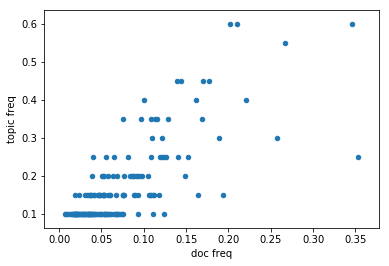

In [86]:
df.plot(kind = "scatter", x = "doc freq", y = "topic freq")

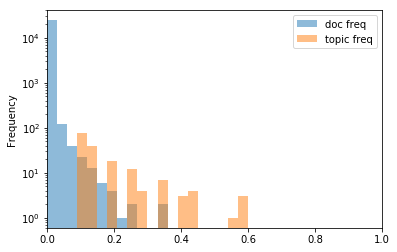

In [96]:
df.plot(kind = "hist", alpha = 0.5, bins = 20)
plt.xlim([0, 1.0])
plt.yscale("log", nonposy = 'clip')
plt.show()

## Observations

Seems like the df gives pretty similar list of words to those that are showing up high in the multiple topics.

Question is what the right df threshold stop level is.

Too high and it won't stop many words.

Too low and it will remove words that are important and informative for topics.

Seems like 10% would be a good level, but can experiment a bit.

## Calculate a list of words to remove based on a document frequency limit.

In [98]:
def calc_df_stopwords(qa_pairs, threshold):
    '''Evaluate a list of qa_pairs and returns a list of words
       have a document frequency higher than the threshold.'''
    
    docf = defaultdict(int)
    total_docs = 0
    for file_id in qa_pairs:
        for q_num in qa_pairs[file_id]:
            q_words = set(qa_pairs[file_id][q_num][0])
            a_words = set(qa_pairs[file_id][q_num][1])
            for word in q_words:
                docf[word] += 1
            for word in a_words:
                docf[word] += 1
            total_docs += 2

    df_stopwords = [w for w in docf if docf[w]*1.0/total_docs > threshold]
    return df_stopwords

calc_df_stopwords(qa_pairs, 0.1)

[u'want',
 u'quarter',
 u'one',
 u'morn',
 u'also',
 u'last',
 u'much',
 u'yeah',
 u'year',
 u'continu',
 u'first',
 u'get',
 u'point',
 u'like',
 u'kind',
 u'take',
 u'littl',
 u'see',
 u'go',
 u'question',
 u'back',
 u'growth',
 u'us',
 u'lot',
 u'look',
 u'NUM',
 u'well',
 u'talk',
 u'thing',
 u'think',
 u'okay',
 u'term',
 u'expect',
 u'busi',
 u'right',
 u'time',
 u'say',
 u'realli',
 u'market',
 u'thank',
 u'good',
 u'bit',
 u'come',
 u'know']